# Further usage

This example shows you a further usage of the windpowerlib and builds on the basic_example.

In this example the power output of a wind farm containing two different wind turbine types is calulated. Apart from that, this example shows you how to calculate the power output of a wind turbine cluster. A cluster can be useful if you want to calculate the feed-in of a region for which you want to use one single weather data grid point.

Functions that are used in the basic usage example, like the initialization of wind turbines, are imported and used without further explanations.

### Imports and initialization of wind turbines

The import of weather data and the initialization of wind turbines is done as in the basic_example.

In [6]:
__copyright__ = "Copyright oemof developer group"
__license__ = "GPLv3"

import basic_example
from windpowerlib.turbine_cluster_modelchain import TurbineClusterModelChain
from windpowerlib.wind_turbine_cluster import WindTurbineCluster
from windpowerlib.wind_farm import WindFarm

import logging
logging.getLogger().setLevel(logging.DEBUG)

In [7]:
# Get weather data
weather = basic_example.get_weather_data('weather.csv')
print(weather[['wind_speed', 'temperature', 'pressure']][0:3])

# Initialize wind turbines
my_turbine, e126 = basic_example.initialize_wind_turbines()
print()
print('nominal power of my_turbine: {}'.format(my_turbine.nominal_power))

variable_name             wind_speed          temperature         pressure
height                            10       80          2       10       0 
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9

nominal power of my_turbine: 3000000.0


### Initialize wind farm

To initialize a specific wind farm you can use a dictionary that contains the basic parameters. A wind farm is defined by its name, wind turbine fleet, and optionally also by a wind farm efficiency and the wind farm's location.

A wind farm efficiency can be a constant value or be dependent on the wind speed. The coordinates are not being used here but are necessary if you need to assign your find farm to a certain weather data point.

In [8]:
# specification of wind farm data
example_farm_data = {
    'name': 'example_farm',
    'wind_turbine_fleet': [{'wind_turbine': my_turbine,
                            'number_of_turbines': 6},
                           {'wind_turbine': e126,
                            'number_of_turbines': 3}
                           ]}
# initialize WindFarm object
example_farm = WindFarm(**example_farm_data)

In [9]:
# specification of wind farm data (2) containing a wind farm efficiency
# and coordinates
example_farm_2_data = {
    'name': 'example_farm_2',
    'wind_turbine_fleet': [{'wind_turbine': my_turbine,
                            'number_of_turbines': 6},
                           {'wind_turbine': e126,
                            'number_of_turbines': 3}],
    'efficiency': 0.9,
    'coordinates': [52.2, 13.1]}

# initialize WindFarm object
example_farm_2 = WindFarm(**example_farm_2_data)

print('nominal power of first turbine type of example_farm_2: {}'.format(
    example_farm_2.wind_turbine_fleet[0]['wind_turbine'].nominal_power))

nominal power of first turbine type of example_farm_2: 3000000.0


### Initialize wind turbine cluster

Like for a wind farm for the initialization of a wind turbine cluster you can use a dictionary that contains the basic parameters. A wind turbine cluster is defined by its name, wind farms and optionally by its location.

In [10]:
# specification of cluster data
example_cluster_data = {
    'name': 'example_cluster',
    'wind_farms': [example_farm, example_farm_2]}

# initialize WindTurbineCluster object
example_cluster = WindTurbineCluster(**example_cluster_data)


### Use the TurbineClusterModelChain to calculate power output

The TurbineClusterModelChain is a class that provides all necessary steps to calculate the power output of a wind farm or wind turbine cluster. 

Like the ModelChain (see basic example) you can use the TurbineClusterModelChain with default parameters as shown here for the wind farm or specify custom parameters as done here for the cluster.
If you use the 'run_model' method first the wind speed and density (if necessary) at hub height are calculated and then used to calculate the power output. 
todo adapt

In [11]:
# power output calculation for example_farm
# initialize TurbineClusterModelChain with default parameters and use
# run_model method to calculate power output
mc_example_farm = TurbineClusterModelChain(example_farm).run_model(weather)
# write power output time series to WindFarm object
example_farm.power_output = mc_example_farm.power_output 

DEBUG:root:Wake losses considered by dena_mean wind efficiency curve.
DEBUG:root:Aggregated power curve smoothed by method: turbulence_intensity
DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [12]:
# set efficiency of example_farm to apply wake losses
example_farm.efficiency = 0.9

# power output calculation for turbine_cluster
# own specifications for TurbineClusterModelChain setup
modelchain_data = {
        'wake_losses_model': 'constant_efficiency',  #
                                           # 'dena_mean' (default), None,
                                           # 'power_efficiency_curve',
                                           # 'constant_efficiency' or name of
                                           #  a wind efficiency curve
                #  see :py:func:`~.wake_losses.display_wind_efficiency_curves`
        'smoothing': True,  # False (default) or True
        'block_width': 0.5,  # default: 0.5
        'standard_deviation_method': 'Staffell_Pfenninger',  #
                                            # 'turbulence_intensity' (default)
                                            # or 'Staffell_Pfenninger'
        'smoothing_order': 'wind_farm_power_curves',  #
                                        # 'wind_farm_power_curves' (default) or
                                        # 'turbine_power_curves'
        'wind_speed_model': 'logarithmic',  # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
        'density_model': 'ideal_gas',  # 'barometric' (default), 'ideal_gas' or
                                       # 'interpolation_extrapolation'
        'temperature_model': 'linear_gradient',  # 'linear_gradient' (def.) or
                                                 # 'interpolation_extrapolation'
        'power_output_model': 'power_curve',  # 'power_curve' (default) or
                                              # 'power_coefficient_curve'
        'density_correction': True,  # False (default) or True
        'obstacle_height': 0,  # default: 0
        'hellman_exp': None}  # None (default) or None
# initialize TurbineClusterModelChain with own specifications and use
# run_model method to calculate power output
mc_example_cluster = TurbineClusterModelChain(
        example_cluster, **modelchain_data).run_model(weather)
# write power output time series to WindTurbineCluster object
example_cluster.power_output = mc_example_cluster.power_output

DEBUG:root:Wake losses considered with constant_efficiency.
DEBUG:root:Aggregated power curve smoothed by method: Staffell_Pfenninger
DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating temperature using temperature gradient.
DEBUG:root:Calculating density using ideal gas equation.
DEBUG:root:Calculating power output using power curve.


### Plot results

If you have matplotlib installed you can visualize the calculated power output.

In [13]:
# try to import matplotlib
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/sabine/virtualenvs/windpowerlib/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


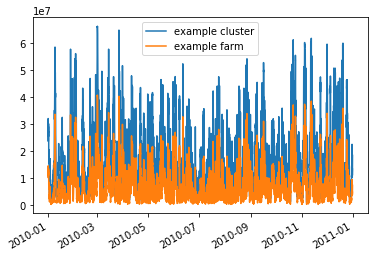

In [14]:
# plot turbine power output
if plt:
    example_cluster.power_output.plot(legend=True, label='example cluster')
    example_farm.power_output.plot(legend=True, label='example farm')
    plt.show()